In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import math, random, sys
import numpy as np
import argparse
from tqdm import tqdm

from hgraph import *
import rdkit
from rdkit.Chem.Draw import IPythonConsole
import mols2grid
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/data/pegasus/not-backed-up/durant/miniconda3/envs/hgvae_old/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from rdkit import rdBase
rdBase.rdkitVersion

'2019.03.4'

In [2]:
# Replicating argument parsing done in original script
parser = argparse.ArgumentParser()
parser.add_argument('--myarg1')
args = parser.parse_args(['--myarg1', ''])
args.vocab = 'data/chembl/vocab.txt' 
args.model = 'ckpt/chembl-pretrained/model.ckpt'
args.nsample = 1000
args.atom_vocab = common_atom_vocab
args.seed = 7
args.rnn_type = 'LSTM'
args.hidden_size = 250
args.embed_size = 250
args.batch_size = 50
args.latent_size = 32
args.depthT = 15
args.depthG = 15
args.diterT = 15
args.diterG = 3
args.dropout = 0.0

In [3]:
# Load vocabulary for the model - may be causing issues with generating models down the line
with open(args.vocab) as f:
    vocab = [x.strip("\r\n ").split() for x in f]
args.vocab = PairVocab(vocab, cuda=False)

In [4]:
# Load model, use pre-generated weights and run on CPU
model = HierVAE(args)
model.load_state_dict(torch.load(args.model, map_location=torch.device('cpu'))[0])

/data/pegasus/not-backed-up/durant/miniconda3/envs/hgvae_old/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


<All keys matched successfully>

In [24]:
# Test, will throw an error sometimes about a specific key pair = KeyError: ('C1=NN=C[NH]1', 'C1=NN=[CH:1]N1')
import time
start_time = time.time()
with torch.no_grad():
    smiles_list = model.sample(100, greedy=True)
print("--- %s seconds ---" % (time.time() - start_time))
mols_list = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
mols2grid.display(mols_list)

KeyError: ('C1=N[NH]C=N1', 'C1=NC=N[NH:1]1')

# Converts random latent space into molecule

In [6]:
def generate_random_latent_space():
    return torch.randn(1, 32).to(device)

In [7]:
def generate_random_molecule():
    smiles = model.decoder.decode((
        generate_random_latent_space(),
        generate_random_latent_space(),
        generate_random_latent_space()),
        greedy=True,
        max_decode_step=150)
    return rdkit.Chem.MolFromSmiles(smiles[0])

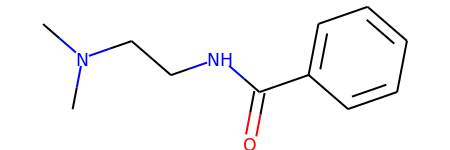

In [8]:
generate_random_molecule()

# To convert molecule into latent space 

In [9]:
from preprocess import tensorize
from hgraph.hgnn import make_cuda

In [10]:
def generate_latent_space_for_mol(model_, smiles):
    molecule_tensor = tensorize(smiles, args.vocab)
    tree_tensors, graph_tensors = make_cuda(molecule_tensor[1])
    root_vecs, tree_vecs, _, graph_vecs = model_.encoder(tree_tensors, graph_tensors)
    vectors, _ = model_.rsample(root_vecs, model_.R_mean, model_.R_var, perturb=False)
    return vectors

In [11]:
def generate_specific_molecule(latent_space_vec):
    smiles = model.decoder.decode(
        (latent_space_vec,
        latent_space_vec,
        latent_space_vec),
        greedy=True,
        max_decode_step=150)
    return [rdkit.Chem.MolFromSmiles(s) for s in smiles]

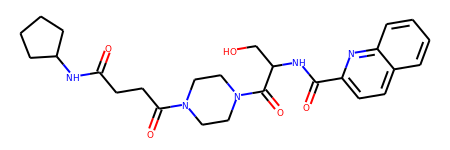

In [12]:
test = [rdkit.Chem.MolToSmiles(generate_random_molecule())]
rdkit.Chem.MolFromSmiles(test[0])

In [13]:
test_vec = generate_latent_space_for_mol(model, test)
print(test_vec)

tensor([[-1.0548e-01,  1.9819e-01, -1.3363e-03,  7.9216e-01, -1.9361e-02,
         -8.5890e-02,  9.5607e-03,  2.2267e-01,  2.5288e-02,  1.5908e-01,
          1.0545e+00,  1.4707e+00,  6.2923e-01, -1.5783e-01, -3.3551e-02,
         -1.5546e+00, -1.9641e+00,  2.8022e-02, -5.4502e-01, -2.8557e-01,
          1.7204e+00,  1.3731e-02,  3.1429e-01, -1.7190e+00, -1.0763e-01,
         -7.1993e-02, -6.3123e-04, -5.7473e-01, -1.4041e-02, -1.9613e-03,
         -2.4158e-01,  7.9370e-02]], grad_fn=<AddmmBackward0>)


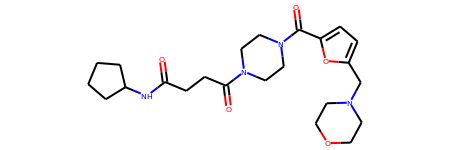

In [14]:
generate_specific_molecule(test_vec)[0]

# Test with Mpro dataset

In [17]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem

In [18]:
def generate_fp(smiles_list):
    return [AllChem.GetMorganFingerprintAsBitVect(rdkit.Chem.MolFromSmiles(smi),2) for smi in smiles_list]

In [19]:
raw_mpro_df = pd.read_csv('submissions.csv')
raw_mpro_df = raw_mpro_df[raw_mpro_df['f_avg_IC50'].notna()]
mpro_smiles = list(raw_mpro_df['SMILES'].values)
print(len(mpro_smiles))

2261


/data/pegasus/not-backed-up/durant/miniconda3/envs/hgvae_old/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (3,9,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
mpro_smiles[:5]

['N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1',
 'N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1',
 'N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1',
 'O=C(Cc1cncc2ccccc12)Nc1ccccc1',
 'N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1']

In [21]:
def remove_hydrogens(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    noH_mol = rdkit.Chem.RemoveHs(mol)
    return rdkit.Chem.MolToSmiles(noH_mol)

mpro_smiles = [remove_hydrogens(s) for s in mpro_smiles]

In [33]:
def remove_troublesome_fragments(smiles_list):
    bad_mols = []
    bad_smile_frags = [
        'C1=CNN=N1',
        'C1=CNN=C1',
        "C1=CNC=C1",
        'C1=CNC=N1',
        'C1=NN=NN1',
        'C1=CC[SH]=C1',
        'C1=NN=CN1',
        'C1=CN=C[NH+]=C1', 
        'C1=NC=NO1', 
        'C1=C[SH]=CC1',
        'C1CCOC1',
        'SS',
    ]
    for s in smiles_list:
        for b in bad_smile_frags:
            patt = rdkit.Chem.MolFromSmiles(b)
            if len(rdkit.Chem.MolFromSmiles(s).GetSubstructMatch(patt)) > 0:
                bad_mols.append(s)
    return [remove_hydrogens(s) for s in smiles_list if s not in bad_mols], bad_mols

In [34]:
mpro_smiles, bad_smiles = remove_troublesome_fragments(mpro_smiles)

In [35]:
mpro_smiles.remove('[2H]C([2H])([2H])O[C@@]1(C(=O)Nc2cncc3ccc(F)cc23)CCOc2ccc(Cl)cc21')

ValueError: list.remove(x): x not in list

In [36]:
mpro_smiles.remove('[2H]C([2H])([2H])O[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21')

ValueError: list.remove(x): x not in list

In [37]:
print(len(mpro_smiles))
print(len(bad_smiles))

1724
585


In [38]:
# sub_mpro_smiles = mpro_smiles[23:53]
# sub_mpro_smiles = mpro_smiles[23:33]
FP_binary_all_atoms = generate_fp(mpro_smiles)

In [39]:
mpro_vec = generate_latent_space_for_mol(model, mpro_smiles)
mpro_vec_detached = mpro_vec.detach().numpy()

KeyboardInterrupt: 

In [ ]:
classifier_all_atoms_ = [list(range(0, 1724))]

In [ ]:
def plot_umap(features, title, classifier_all_atoms):
    reducer = umap.UMAP()
    umap_binary_all_atoms = reducer.fit_transform(features)
    plt.scatter(umap_binary_all_atoms[:,0],
               umap_binary_all_atoms[:,1],
               c=classifier_all_atoms, 
                cmap="plasma")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)
    plt.show()
    return None

In [ ]:
plot_umap(FP_binary_all_atoms, "UMAP analysis of Mpro inhibitors' ECFP4 fingerprints", classifier_all_atoms_)

In [ ]:
plot_umap(mpro_vec_detached, "UMAP analysis of Mpro inhibitors' latent variables", classifier_all_atoms_)

# SAMPLING FUNCTIONS

In [29]:
def random_sample(matrix):
    """Randomly samples values between the minimum and maximum values
    provided in a matrix and therefore interpolates within the latent
    space specified.
    """
    random_sample_latent_space = []
    for col in matrix.T:
        minimum = min(col)
        maximum = max(col)
        random_sample_latent_space.append(random.uniform(minimum, maximum))
    return np.array(random_sample_latent_space)
        

In [30]:
def tensor_to_numpy(latent_tensors):
    return latent_tensors.detach().numpy()

In [31]:
def numpy_to_tensor(latent_arrays):
    return torch.from_numpy(latent_arrays)

In [32]:
mols_to_interpolate = mpro_smiles
raw_latent_variables = generate_latent_space_for_mol(model, mols_to_interpolate)
np_latent_variables = tensor_to_numpy(raw_latent_variables)

KeyError: 'C1=CNN=N1'

In [ ]:
sampled_latent_variables = np.array([random_sample(np_latent_variables) for _ in range(1000)], dtype=np.float16)
sampled_latent_tensor = numpy_to_tensor(np.array(sampled_latent_variables, dtype=np.float16))
mols_sampled = generate_specific_molecule(sampled_latent_tensor.float())

In [ ]:
mols2grid.display([rdkit.Chem.MolFromSmiles(smi) for smi in mols_to_interpolate])

In [ ]:
mols2grid.display(mols_sampled)

In [ ]:
mols_sampled_features = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in mols_sampled]
mols_sampled_labels = [0 for _ in mols_sampled]
mols_to_interpolate_features = generate_fp(mols_to_interpolate)
mols_to_interpolate_labels = [1 for _ in mols_to_interpolate]
all_labels = mols_to_interpolate_labels + mols_sampled_labels
all_features = mols_to_interpolate_features + mols_sampled_features

In [ ]:
plot_umap(all_features, "UMAP analysis of Mpro inhibitors' (yellow)\n and generated molecules (blue) ECFP4 fingerprints\n", all_labels)